In [1]:
# 导入必要的函数库
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import serial
from PIL import Image
import pylab as pl
from scipy import ndimage
import scipy.ndimage
import threading
import time
from matplotlib.patches import Polygon

In [7]:
# 打开摄像头，占用内存大，不轻易运行
capture=cv2.VideoCapture(1)

In [8]:
# 拍照，保存一张照片
def take_photo(photo_name):
    global capture
    photo_name=photo_name+'.jpg'
    _,image=capture.read()
    cv2.imwrite(photo_name,image)

In [9]:
# 在某一图像的指定位置添加图案
kernel = np.array([
[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
[0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0],
[0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
[0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
])*255
def draw_image(image_gray_to_draw, kernel_point):
    if (int(kernel_point[0]-11)>0)&(int(kernel_point[0]+11)<480)&(int(kernel_point[1]-11)>0)&(int(kernel_point[1]+11)<640):
        image_gray_to_draw[int(kernel_point[0]-11):int(kernel_point[0]+11),int(kernel_point[1]-11):int(kernel_point[1]+11)]=kernel*255
    else:
        image_gray_to_draw[240-11:240+11,320-11:320+11]=kernel*255
    return image_gray_to_draw

In [10]:
# 获取球坐标
# def get_ball():


In [11]:
# 图像的映射变换
def photo_transform(ad,origin,border_point):
    # 原先的四个角的边缘点
    pts = np.float32([[0,0],[0,origin.shape[1]],[origin.shape[0],origin.shape[1]],[origin.shape[0],0]])
    # 由于变换的特殊性，这里后面的点是列行，反着来的
    border_point_1=np.zeros(np.shape(border_point))
    border_point_1[:,0]=border_point[:,1]
    border_point_1[:,1]=border_point[:,0]
    pts1 = np.float32(border_point_1)
    # 生成最为关键的变换矩阵
    M = cv2.getPerspectiveTransform(pts,pts1)
    # 变换正方形
    square_trans = cv2.warpPerspective(origin,M,(ad.shape[1],ad.shape[0]))
    square_trans = cv2.cvtColor(square_trans, cv2.COLOR_RGB2GRAY)
    _, square_trans = cv2.threshold(square_trans, 127, 255, cv2.THRESH_BINARY)
    return square_trans

In [12]:
# 获取并处理图像
def get_image():
    # while True:
        # 开全局变量处理，分理处红绿蓝
        global image, image_red, image_green, image_blue
        # 从摄像头获取图像
        _,image=capture.read()
        # image=cv2.imread('1.jpg')
        image_red=image[:,:,2].astype(np.float32)
        image_green=image[:,:,1].astype(np.float32)
        image_blue=image[:,:,0].astype(np.float32)
        # cv2.imshow('image_red_only',image_red_only)
        # cv2.waitKey(1)

# 获取图像单独开进程
# get_image_threading = threading.Thread(target=get_image)
# get_image_threading.start()

In [13]:
# 突出图像中的红色目标
def get_red():
    global image, image_red, image_green, image_blue
    image_red_only=image_red*2-image_blue-image_green
    image_red_only[image_red_only<0]=0
    image_red_only_photo=image_red_only.astype(np.uint8)
    return image_red_only_photo, image_red_only

In [14]:
# 突出图像中的绿色目标
def get_green():
    global image, image_red, image_green, image_blue
    image_green_only=image_green*2-image_blue-image_red
    image_green_only[image_green_only<0]=0
    image_green_only_photo=image_green_only.astype(np.uint8)
    return image_green_only_photo, image_green_only

In [15]:
# 突出图像中的蓝色目标
def get_blue():
    global image, image_red, image_green, image_blue
    image_blue_only=image_blue*2-image_blue-image_red
    image_blue_only[image_blue_only<0]=0
    image_blue_only_photo=image_blue_only.astype(np.uint8)
    return image_blue_only_photo, image_blue_only

In [16]:
# 展示图片
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [50]:
ex1=get_image()

In [51]:
ex1_red, ex1_red_photo=get_red()
# 阈值分割图像
ex1_red=cv2.threshold(ex1_red, 200, 255, cv2.THRESH_BINARY)[1]

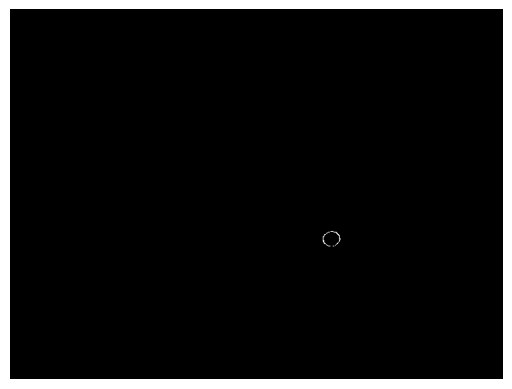

In [52]:
show_image(ex1_red)

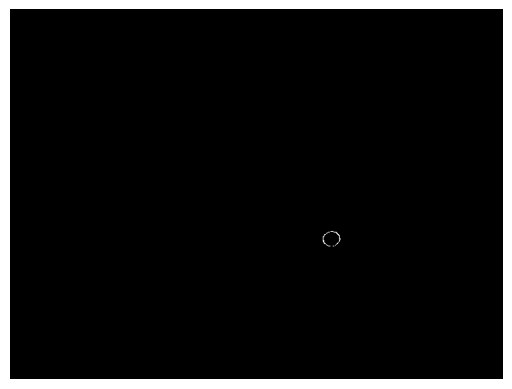

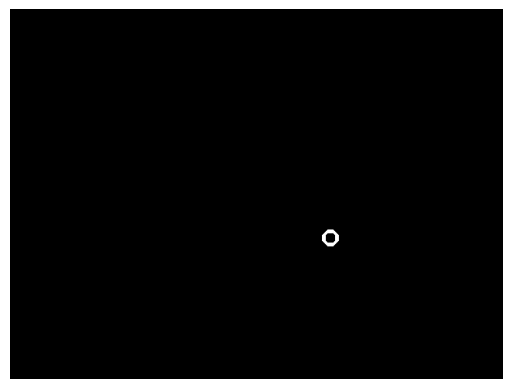

In [53]:
show_image(ex1_red)
# 找出ex1_red中大于255的
red_point=np.where(ex1_red>200)
red_point=np.mean(red_point,axis=1)
ex1_red_photo=draw_image(ex1_red_photo,red_point)
show_image(ex1_red_photo)

In [54]:
print(red_point)

[297.03125 416.90625]


In [55]:
center_point=np.array([14.2,325.9])

In [56]:
def red_point_char(red_point):
    red_point_x=int(red_point[0]*10)
    red_point_y=int(red_point[1]*10)
    red_point_send='X'+str(int(red_point_x/1000))+str(int((red_point_x/100)%10))+'.'+str(int((red_point_x/10)%10))+str(int((red_point_x)%10))+'Y'+str(int(red_point_y/1000))+str(int((red_point_y/100)%10))+'.'+str(int((red_point_y/10)%10))+str(int((red_point_y)%10))
    return red_point_send

In [57]:
print(red_point_char(red_point))

X29.70Y41.69


In [3]:
R

9.046249999999999

In [4]:
R=(30.70-12.33+40.55-22.81+31.68-13.59+41.69-23.52)/8
p=8
A=360/p
p7x=[]
p7y=[]
for i in range(p):
    px=21.42+6*math.cos(math.radians(A*i))
    py=32.59+6*math.sin(math.radians(A*i))
    p7x.append(px)
    print(px)
    p7y.append(py)
    print(py)


27.42
32.59
25.662640687119286
36.83264068711929
21.42
38.59
17.177359312880718
36.83264068711929
15.420000000000002
32.59
17.177359312880718
28.34735931288072
21.42
26.590000000000003
25.662640687119286
28.34735931288072


In [5]:
print(p7x)

[27.42, 25.662640687119286, 21.42, 17.177359312880718, 15.420000000000002, 17.177359312880718, 21.42, 25.662640687119286]


In [6]:
print(p7y)

[32.59, 36.83264068711929, 38.59, 36.83264068711929, 32.59, 28.34735931288072, 26.590000000000003, 28.34735931288072]


In [ ]:
21.42, 25.66,27.42, 25.66, 21.42, 17.17, 15.42, 17.17,21.42, 25.66,27.42, 25.66, 21.42, 17.17, 15.42, 17.17,21.42, 25.66,27.42, 25.66, 21.42, 17.17, 15.42,17.17,21.42,25.66,

In [ ]:
19.17,17.42,19.17,23.42,27.66,29.42,27.66,23.42,19.17,17.42,19.17,23.42,27.66,29.42,27.66,23.42,19.17,17.42,19.17,23.42,27.66,29.42,27.66,23.42,